<a href="https://colab.research.google.com/github/iishutov/CV-Project/blob/master/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset

In [ ]:
!pip install keras-tuner -q

import os
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, regularizers
import keras_tuner
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
! rm -rf sample_data
! rm -rf colored
! mkdir colored

train_dir = '/content/colored/train'
test_dir = '/content/colored/test'

train_dir_zip = '/content/drive/MyDrive/ML/my-dataset/train.zip'
test_dir_zip = '/content/drive/MyDrive/ML/my-dataset/test.zip'
# import folders from Google Drive with a dataset and unzip them.
for zip_dir, dir in zip((train_dir_zip, test_dir_zip), (train_dir, test_dir)):
  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(dir)

In [ ]:
# Converting images to grayscale format.
! rm -rf grayscale
! mkdir -p grayscale/train; cd grayscale/train; mkdir empty full/; cd
! mkdir -p grayscale/test; cd grayscale/test; mkdir empty full/; cd

train_grayscale_dir = '/content/grayscale/train'
test_grayscale_dir = '/content/grayscale/test'

for colored_dir, grayscale_dir in zip((train_dir, test_dir), (train_grayscale_dir, test_grayscale_dir)):
  for container_class in 'empty', 'full':
    c_class_dir = os.path.join(colored_dir, container_class)
    g_class_dir = os.path.join(grayscale_dir, container_class)
    for filename in os.listdir(c_class_dir):
      img = cv2.imread(os.path.join(c_class_dir, filename), 0)
      cv2.imwrite(os.path.join(g_class_dir, filename), img)

train_dir = train_grayscale_dir
test_dir = test_grayscale_dir

# Preprocessing

In [ ]:
batch_size = 32
rescale = 1./255
img_height = img_width = 128

In [ ]:
# Training dataset preprocessing
train_datagen = ImageDataGenerator(
    rescale=rescale,
    horizontal_flip=True,
    #rotation_range=20,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=0.2,
    #zoom_range=0.2,
    #fill_mode='nearest',
    #brightness_range=(0.8, 1.2),
    #channel_shift_range=50
)

train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42,
)

Found 630 images belonging to 2 classes.


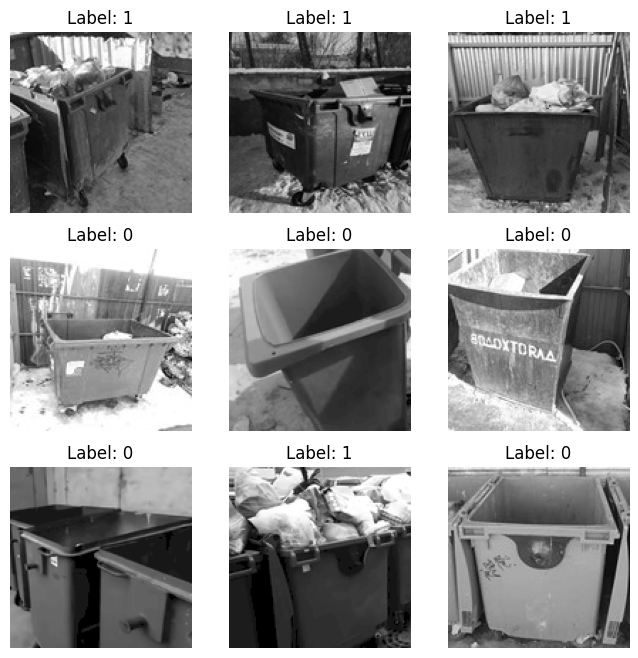

In [ ]:
# Show the resulted training dataset after augmentation.
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        image, label = train_dataset.next()
        axs[i,j].imshow(image[0], cmap='gray')
        axs[i,j].set_title(f'Label: {(int)(label[0])}')
        axs[i,j].axis('off')
plt.show()

In [ ]:
# Testing dataset preprocessing (normalization).
test_datagen = ImageDataGenerator(rescale=rescale)

test_dataset = test_datagen.flow_from_directory(
    directory=test_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 160 images belonging to 2 classes.


# Model building and fine-tuning

In [ ]:
def build_model(hp):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.000), padding='same', input_shape=(img_height, img_width, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.000), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.000), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.000), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.000), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.000)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )
  return model

def plot_metrics(history):
  fig, (axs_loss, axs_acc) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
  for axs, metric in zip([axs_loss, axs_acc], ['loss', 'accuracy']):
    axs.set_title(f'Model {metric}')
    axs.set_ylabel(f'{metric}')
    axs.set_xlabel('epoch')
    axs.plot(history.history[f'{metric}'], label='Train')
    axs.plot(history.history[f'val_{metric}'], label='Validation')
    axs.legend(loc='lower right')
    axs.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

  fig.subplots_adjust(wspace=0.5)
  plt.show()

Epoch 1/15
20/20 [==============================] - 29s 1s/step - loss: 0.6761 - accuracy: 0.5937 - val_loss: 0.6587 - val_accuracy: 0.6000
Epoch 2/15
20/20 [==============================] - 27s 1s/step - loss: 0.6466 - accuracy: 0.6381 - val_loss: 0.6139 - val_accuracy: 0.6125
Epoch 3/15
20/20 [==============================] - 28s 1s/step - loss: 0.6042 - accuracy: 0.6778 - val_loss: 0.6792 - val_accuracy: 0.6187
Epoch 4/15
20/20 [==============================] - 29s 1s/step - loss: 0.5516 - accuracy: 0.7333 - val_loss: 0.7141 - val_accuracy: 0.6750
Epoch 5/15
20/20 [==============================] - 29s 1s/step - loss: 0.4568 - accuracy: 0.7905 - val_loss: 0.4746 - val_accuracy: 0.7812
Epoch 6/15
20/20 [==============================] - 33s 2s/step - loss: 0.3901 - accuracy: 0.8460 - val_loss: 0.3333 - val_accuracy: 0.8250
Epoch 7/15
20/20 [==============================] - 29s 1s/step - loss: 0.3257 - accuracy: 0.8603 - val_loss: 0.3500 - val_accuracy: 0.8313
Epoch 8/15
20/20 [==

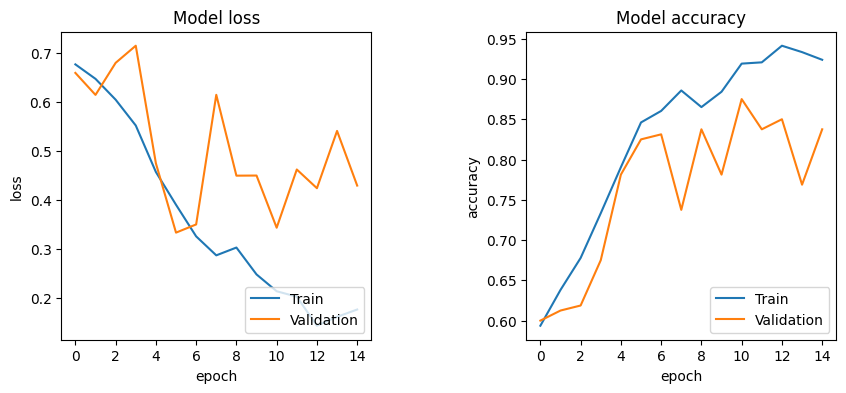

In [ ]:
# Hyperparameters tuning.
# tuner = keras_tuner.RandomSearch(
#     hypermodel=build_model,
#     objective="val_accuracy",
#     max_trials=10,
#     executions_per_trial=2,
#     overwrite=True,
#     directory="/content/tuning",
#     project_name="dropout",
# )
# tuner.search_space_summary()
# tuner.search(
#     train_dataset,
#     epochs=15,
#     validation_data=test_dataset,
#     callbacks=[tf.keras.callbacks.EarlyStopping("val_accuracy", patience=3)]
#     )
# model = tuner.get_best_models(num_models=1)[0]

# Training the model.
model = build_model(None)
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=test_dataset,
    )
plot_metrics(history)

In [ ]:
tuner.results_summary()

Results summary
Results in /content/tuning/dropout
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
dropout: 0.6
Score: 0.8656249940395355


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 64)      

# Predicting

5/5 [==============================] - 3s 571ms/step


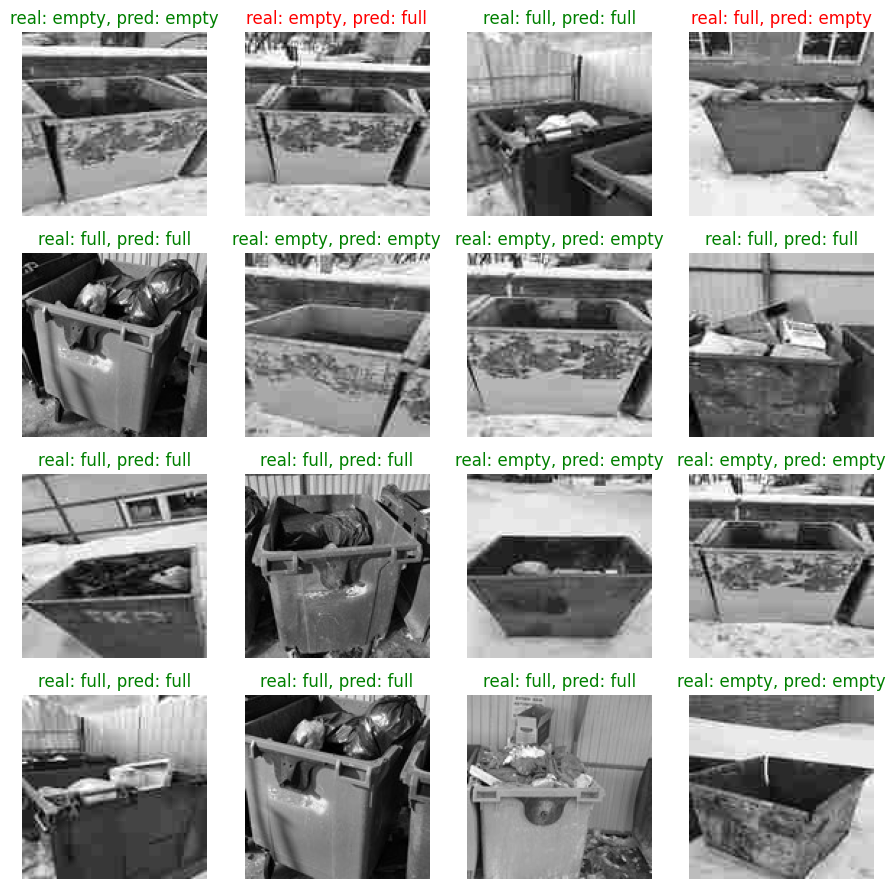

In [ ]:
# Result.
predictions = model.predict(test_dataset)

idx = 0
rng = np.random.default_rng()
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(11,11))

for i in range(4):
  for j in range(4):
    image, label = test_dataset.next()
    _batch_size = label.shape[0]
    
    local_idx = (int)(_batch_size * rng.uniform())
    global_idx = (idx + local_idx) % len(predictions)

    real_class = 'full' if np.round(label[local_idx]) else 'empty'
    predicted_class = 'full' if np.round(predictions[global_idx][0]) else 'empty'

    axs[i,j].set_title(f'real: {real_class}, pred: {predicted_class}')\
      .set_color('green' if real_class == predicted_class else 'red')
    axs[i,j].imshow(image[local_idx], cmap='gray')
    axs[i,j].axis('off')

    idx += _batch_size

plt.show()

In [ ]:
model.save("container_classifier.h5")

# Testing on other datasets

/content/testing/Sob/grayscale/empty
/content/testing/Sob/grayscale/full
Found 186 images belonging to 2 classes.
6/6 [==============================] - 2s 310ms/step


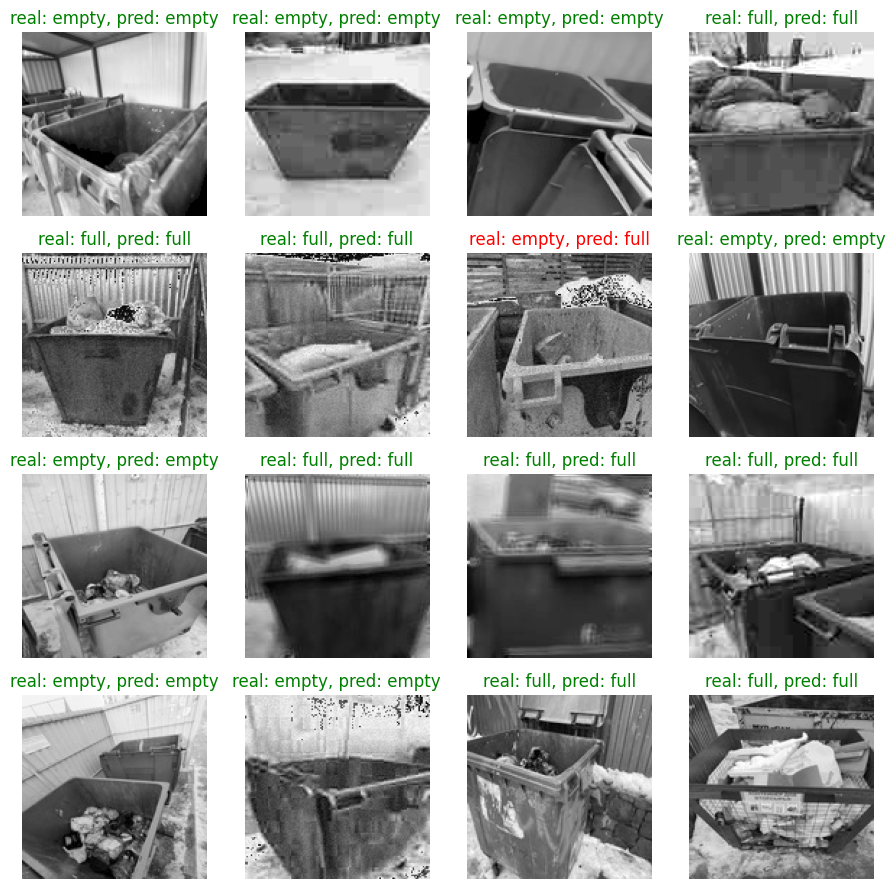

In [87]:
! rm -rf testing/Sob
! mkdir -p testing/Sob/grayscale/empty testing/Sob/grayscale/full

zip_dir = '/content/drive/MyDrive/ML/test_Sob.zip'
dir = '/content/testing/Sob'
with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(dir)

test_dir = colored_dir = '/content/testing/Sob/test'
grayscale_dir = '/content/testing/Sob/grayscale'

for container_class in 'empty', 'full':
  c_class_dir = os.path.join(colored_dir, container_class)
  g_class_dir = os.path.join(grayscale_dir, container_class)
  print(g_class_dir)
  for filename in os.listdir(c_class_dir):
    img = cv2.imread(os.path.join(c_class_dir, filename), 0)
    cv2.imwrite(os.path.join(g_class_dir, filename), img)

test_dir = grayscale_dir

test_dataset = test_datagen.flow_from_directory(
    directory=test_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)
model.evaluate(test_dataset)
predictions = model.predict(test_dataset)

idx = 0
rng = np.random.default_rng()
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(11,11))

for i in range(4):
  for j in range(4):
    image, label = test_dataset.next()
    _batch_size = label.shape[0]
    
    local_idx = (int)(_batch_size * rng.uniform())
    global_idx = (idx + local_idx) % len(predictions)

    real_class = 'full' if np.round(label[local_idx]) else 'empty'
    predicted_class = 'full' if np.round(predictions[global_idx][0]) else 'empty'

    axs[i,j].set_title(f'real: {real_class}, pred: {predicted_class}')\
      .set_color('green' if real_class == predicted_class else 'red')
    axs[i,j].imshow(image[local_idx], cmap='gray')
    axs[i,j].axis('off')

    idx += _batch_size

plt.show()